# Over dit document
In dit document wordt een CRISP-DM cycles doorlopen, welke vervolgens een dataproduct (visualisaties) op zal leveren. Tot slot wordt er een conclusie getrokken en advies gegeven. Hiervoor is ter ondersteuning het Data Ethics Decision Aid model (DEDA model) voor gebruikt.

Auteur: Eefkje-Femke Jansen van der Sligte

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, BisectingKMeans
df=pd.read_excel("Complete-dataset-FINAL.xlsx")

pd.options.mode.chained_assignment = None  # default='warn'

# Business Understanding
Het Isala ziekenhuis wil de zorg voor diabetespatiënten verbeteren. Het gaat hier specifiek om het behandelproces. Door onnauwkeurigheden in metingen te filteren en hierop een behandelplan aan te passen, zal er een verbetering optreden in de analyse. Visualisaties zullen helpen bij het verkrijgen van inzicht in de foutmarges van diverse meetmethoden. Op dit moment zijn er geen visualisaties die dat in kaart brengen. 

Om meer inzicht te bieden willen we gaan kijken naar mogelijke relaties die er nog niet zijn. Dit zal worden gedaan door het clusteren van de Amerikaanse meetmethoden. Deze clusters kunnen vervolgens gebruikt worden om nieuwe inzichten te verkrijgen van de meetmethode zoals de invloed van variabelen.


# Data Understanding
Welke databronnen zijn gegeven en in welk formaat: Een excel bestand genaamd: Complete-dataset-FINAL.xlsx

#### note
Het excel bestand dat gebruikt gaat worden, is het resultaat van rapporten die om zijn gezet naar excel. Dit is de meest recente versie waarin de meetmethoden zijn genormaliseerd en de waarden dubbelgecheckt zijn.

Hoe groot zijn deze databronnen: 355 kB

-4685 rijen

-12 kolommen

Kolomnamen: Method name, N (no. labs), Mean, Bias, CV, Sample, Reference value, Year, Source, Type, Manufacturer (fabrikant).
- Method name : Naam van het meetapparaat
- N	: Aantal labs
- Mean :  Gemiddelde van alle HbA1c waarde
- Bias : Absolute toe- of afname van de hoeveelheid mmol/mol ten opzichte van de werkelijke waarde
- CV : Laat zien wat de spreiding is de metingen
- Sample : Hoeveelste meting in het jaar
- Reference Value : Variabel die is gebaseerd op 95% van de gezonde populatie	
- Year : Welk jaar de meting is gedaan
- Source	: Amerikaans of Europese data
- Type : Vers of bevroren bloed

Datatypes: Object, float en int (jaar) 


In [2]:
df.head()

,Method name,N (no. labs),Mean,Bias,CV,Sample,Reference Value,Year,Source (CAP/EurA1c),Type (Fresh/frozen),Manufacturer,Total Error
0,Vitros 5.1 FS. 4600. 5600,183,6.14,-0.16,2.3,GH2-04,6.3,2011.0,CAP,Fresh,Vitros,4.348
1,Vitros 5.1 FS. 4600. 5600,183,7.59,-0.01,2.5,GH2-05,7.6,2011.0,CAP,Fresh,Vitros,4.890
2,Vitros 5.1 FS. 4600. 5600,183,9.42,0.22,3.0,GH2-06,9.2,2011.0,CAP,Fresh,Vitros,6.100
3,Vitros 5.1 FS. 4600. 5600,210,5.42,-0.18,2.3,GH2-01,5.6,2012.0,CAP,Fresh,Vitros,4.328
4,Vitros 5.1 FS. 4600. 5600,210,9.34,-0.06,2.6,GH2-02,9.4,2012.0,CAP,Fresh,Vitros,5.036


In [3]:
df.dtypes

Method name             object
N (no. labs)            object
Mean                   float64
Bias                   float64
CV                     float64
Sample                  object
Reference Value        float64
Year                   float64
Source (CAP/EurA1c)     object
Type (Fresh/frozen)     object
Manufacturer            object
Total Error            float64
dtype: object

In [4]:
df.isna().sum()

Method name              4
N (no. labs)             4
Mean                    86
Bias                   630
CV                     104
Sample                   4
Reference Value         32
Year                     4
Source (CAP/EurA1c)      4
Type (Fresh/frozen)      4
Manufacturer             4
Total Error              0
dtype: int64

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Mean,4602.0,7.388795,1.896549,4.60,5.780,7.100,8.7000,19.200
Bias,4058.0,0.073361,0.650975,-6.90,-0.090,0.020,0.1300,6.500
CV,4584.0,2.972033,1.420669,0.50,2.100,2.700,3.5000,17.100
Reference Value,4656.0,7.361971,1.864492,4.92,5.800,7.100,8.6500,13.000
Year,4684.0,2015.568531,4.261448,2006.00,2013.000,2017.000,2019.0000,2021.000
Total Error,4688.0,5.759460,2.978506,0.00,3.976,5.194,6.7955,28.216


In [6]:
df.columns

Index(['Method name', 'N (no. labs)', 'Mean', 'Bias', 'CV', 'Sample',
       'Reference Value', 'Year', 'Source (CAP/EurA1c)', 'Type (Fresh/frozen)',
       'Manufacturer', 'Total Error'],
      dtype='object')

# Data Preparation

In deze fase zal de dataframe aangepast worden om een clustermodel toe te kunnen passen. 
De volgende vragen zijn als richtlijn gebruikt om de data voor te bereiden:

- Moet er nog een kolom weg?
- Zijn er aanpassingen nodig aan de data voordat we met modelling aan de slag kunnen?
- Moet het nog genormaliseerd worden?
- Zijn er lege velden?

In [7]:
#Scheidt de data en verwijder obect kolommen voor clustering
df_CAP=df.loc[df['Source (CAP/EurA1c)'] == 'CAP']
df_CAP = df_CAP.drop(columns=['N (no. labs)', 'Source (CAP/EurA1c)', 'Type (Fresh/frozen)', 'Manufacturer', 'Sample', 'Method name' , 'Total Error' , 'Bias']) # kolomm weggooien

df_CAP.shape

(4170, 4)

In [8]:
df_CAP.isna().sum()

Mean                82
CV                 100
Reference Value     28
Year                 0
dtype: int64

In [9]:
#verwijder alleen rijen die volledig leeg zijn
df_CAP = df_CAP.dropna(how='all')
df_CAP.isna().sum()

Mean                82
CV                 100
Reference Value     28
Year                 0
dtype: int64

## Note
Hier zijn veel waardes die missen. In de rapporten is er een bewuste keuze gemaakt om bij een bepaalde meting geen reference value mee te geven (door een te grote spreiding). Verder zijn bij de rijen waarbij de 'CV' leeg is, vrijwel ook de 'Mean' en de 'Bias' leeg. Hierdoor dragen deze rijen weinig bij aan de cluster analyse gebaseerd op deze waarden. Daarom is het besluit genomen om alle rijen die lege waarden bevatten te verwijderen.

In [10]:
df_CAP = df_CAP.dropna()
df_CAP.isna().sum()

Mean               0
CV                 0
Reference Value    0
Year               0
dtype: int64

In [11]:
#omzetten van object kolommen naar float kolommen voor de clustering
df_CAP["Mean"] = df_CAP["Mean"].replace("-", np.nan)
df_CAP["Mean"] = pd.to_numeric(df_CAP["Mean"])

df_CAP["CV"] = df_CAP["CV"].replace("-", np.nan)
df_CAP["CV"] = df_CAP["CV"].replace(" ", np.nan)
df_CAP["CV"] = pd.to_numeric(df_CAP["CV"])

df_CAP.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4042 entries, 0 to 4683
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Mean             4042 non-null   float64
 1   CV               4042 non-null   float64
 2   Reference Value  4042 non-null   float64
 3   Year             4042 non-null   float64
dtypes: float64(4)
memory usage: 157.9 KB


## Data analyse
Er is bewust de keuze gemaakt om voor de model fase de data te inventariseren. Dit is alleen ter observatie en schetst een beeld van de gehele dataset. Dit zal worden gedaan a.d.h.v. de 8v's. Namelijk Volume, Velocity, Variety, Variability, Varicity, Validity, Volatility en Visualisation.


- Volume: 355 kB, 4685 rijen en 12 kolommen. De volume zal gedurende het project niet veranderen.
- Velocity: het snel verwerken van de data is nu niet van belang. Per jaar worden 3-4 nieuwe rapporten gepubliceerd. 
- Variety: de dataset bevat meetmethodes en metingen (denk aan'Method name'). Daarnaast zijn er nog variabelen die de meetmethodes en metingen hebben ondersteund (denk aan 'Reference value'). Tot slot zijn er nog variabelen die een meting uniek maakt (denk aan 'Year' en 'Type').
- Variability: De dataset bevat medische resultaten van metingen. Deze metingen zijn statisch en de betekenis zal niet veranderen. Verder is de structuur van de data afgestemd op een dataformaat.
- Varicity: deze dataset bevat het eindresultaat van het constant valideren en checken van de kwaliteit van de data. Rijen die lege waarden bevatten, zullen niet gelijk worden verwijderd. De keuze bij deze clusteranalyse om specifieke rijen te verwijderen wordt in de data preparation gemaakt.  
- Validity: de gebruikte dataset is het resultaat van gepubliceerde medische rapporten om te zetten naar dataframes. In dat proces zijn waarden absoluut niet aangepast. 
- Volatility: de dataset bevat medische resultaten van metingen. Deze metingen zijn statisch en de betekenis zal niet veranderen.
- Visualisation: voor de visualisatie wordt er een pairplot en heatmap gebruikt.

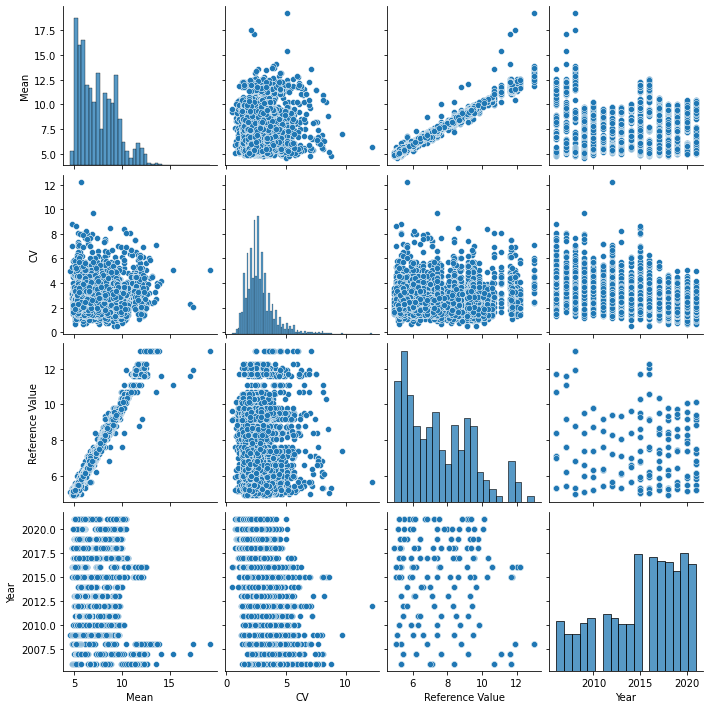

In [12]:
sns.pairplot(df_CAP)

<AxesSubplot:>

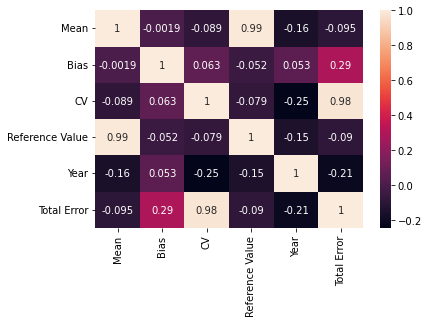

In [13]:
sns.heatmap(df.corr(), annot=True)

# Data analyse bevindingen
- In de heatmap is terug te zien dat de meeste variabelen geen tot amper een correlatie aantonen. Behalve de correlatie van 1 met de variabelen 'reference value' en de 'mean'.
- In de pairplot is een linear verband te zien tussen de 'reference value' en de 'mean'. De 'mean'-waarde wordt gebruikt om de 'reference value' te berekenen.
- In de pairplot is bij de 'Reference value' ook een opmerkelijk gat te zien. 

# Modeling
## Aantal clusters bepalen met een elbow plot

<AxesSubplot:>

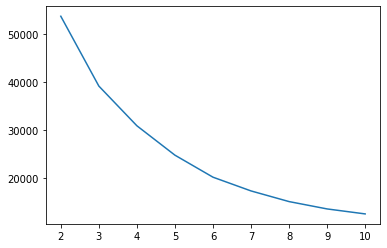

In [14]:
df_model = df_CAP.copy()

n_clusters_to_test = range(2, 11)
inertias = []

for n in n_clusters_to_test:
    model = KMeans(n_clusters=n).fit(df_model)
    inertias.append(model.inertia_)
    
sns.lineplot(x=n_clusters_to_test, y=inertias)

# Eerste model met KMeans
De keuze om het juiste aantal clusters te kiezen, heb ik gebaseerd op het kleinste aantal cluster met de grootste knik. In dit geval is dat bij 3 clusters.

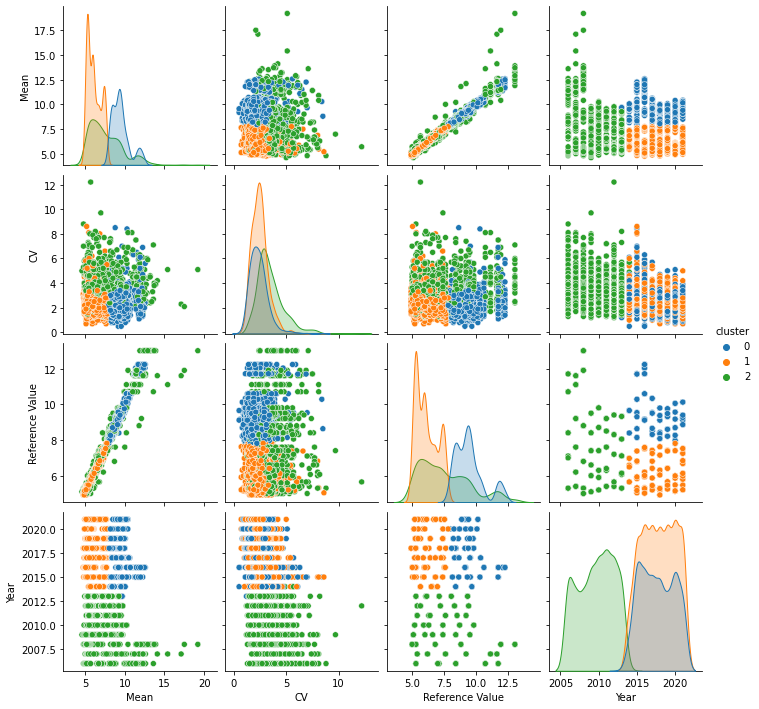

In [15]:
model = KMeans(n_clusters=3, random_state=42).fit(df_model)
df_model['cluster'] = model.labels_
df_model['cluster'] = df_model['cluster'].astype('category')
sns.pairplot(df_model, hue='cluster')

# Analyse pair plot
De rechte banden in de onderste rij - rechts, overlappen elkaar. Hieruit kan worden geconcludeerd dat de data niet genormaliseerd hoeft te worden.

Opvallende punten bij de clusters:
- Cluster 0 en cluster 2 bestaan vrijwel uit recente datapunten, waarvan de datapunten aan de lage kant liggen bij de 'CV'-waarde.
- Bij cluster 1 is de data vooral gefocust op de eerdere jaren tussen 2009 en 2016.
- Bij cluster 1 is ook te zien dat de datapunten die aan de buitenkant liggen van de lineare stijging van de 'Reference value' in deze cluster zijn verdeeld.
- Bij cluster 2 is te zien dat een lage 'CV'-waarde gegroupeerd wordt met hoge 'Mean'-waarden. Verder hebben deze datapunten vrijwel een hogere refrence value.

# Cluster analyse

In [16]:
cluster_0 = df_model[df_model['cluster'] == 0]
cluster_1 = df_model[df_model['cluster'] == 1]
cluster_2 = df_model[df_model['cluster'] == 2]
df_model['cluster'].value_counts()

1    1669
2    1282
0    1091
Name: cluster, dtype: int64

<AxesSubplot:xlabel='cluster', ylabel='CV'>

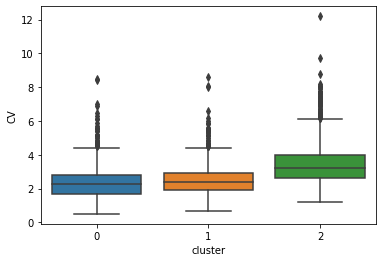

In [17]:
sns.boxplot(x='cluster', y='CV', data=df_model)

<AxesSubplot:xlabel='cluster', ylabel='Mean'>

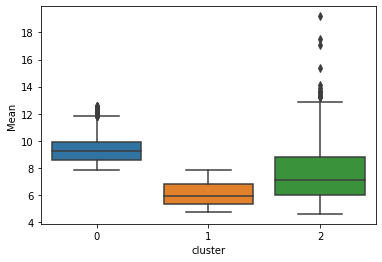

In [18]:
sns.boxplot(x='cluster', y='Mean', data=df_model)

<AxesSubplot:xlabel='cluster', ylabel='Reference Value'>

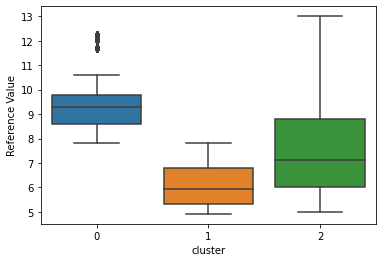

In [19]:
sns.boxplot(x='cluster', y='Reference Value', data=df_model)

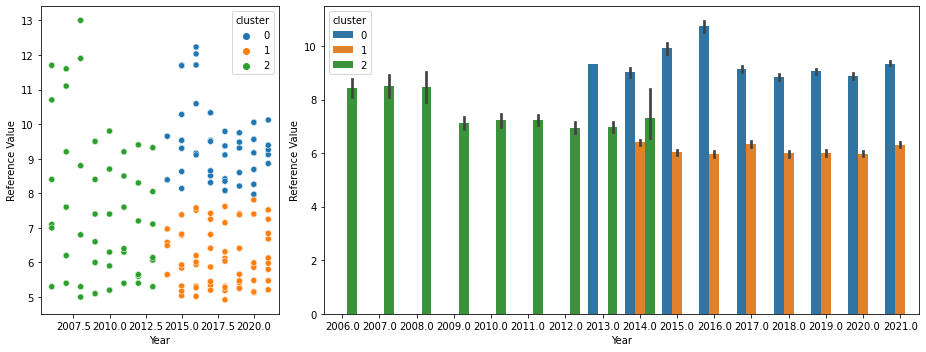

In [20]:
f, axs = plt.subplots(1, 2, figsize=(13, 5), gridspec_kw=dict(width_ratios=[2, 5]))
sns.scatterplot(data=df_model, x='Year', y='Reference Value', hue="cluster", ax=axs[0])
sns.barplot(x='Year', y='Reference Value', data=df_model, hue='cluster',  ax=axs[1])
f.tight_layout()

In [21]:
df_cluster_0 = pd.DataFrame(columns=['Method name', 'N (no. labs)', 'Mean', 'Bias', 'CV', 'Sample',
       'Reference Value', 'Year', 'Source (CAP/EurA1c)', 'Type (Fresh/frozen)',
       'Manufacturer', 'Total Error'])
df_cluster_0 = df.loc[cluster_0.index, :]
df_cluster_0['cluster'] = 0
df_cluster_0.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Mean,1091.0,9.437360,1.105512,7.84,8.590,9.270,9.880,12.58
Bias,1091.0,0.007599,0.173396,-0.67,-0.100,0.020,0.120,0.87
CV,1091.0,2.364895,0.910321,0.50,1.700,2.300,2.800,8.50
Reference Value,1091.0,9.429762,1.102081,7.81,8.600,9.300,9.790,12.23
Year,1091.0,2017.626031,2.157432,2013.00,2016.000,2018.000,2020.000,2021.00
Total Error,1091.0,4.642792,1.771636,0.88,3.424,4.448,5.485,16.82
cluster,1091.0,0.000000,0.000000,0.00,0.000,0.000,0.000,0.00


In [22]:
df_cluster_1 = pd.DataFrame(columns=['Method name', 'N (no. labs)', 'Mean', 'Bias', 'CV', 'Sample',
       'Reference Value', 'Year', 'Source (CAP/EurA1c)', 'Type (Fresh/frozen)',
       'Manufacturer', 'Total Error'])
df_cluster_1 = df.loc[cluster_1.index, :]
df_cluster_1['cluster'] = 1
df_cluster_1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Mean,1669.0,6.114116,0.835619,4.750,5.360,5.950,6.810,7.860
Bias,1669.0,0.003068,0.112253,-0.410,-0.070,0.000,0.080,0.430
CV,1669.0,2.466207,0.829794,0.700,1.900,2.400,2.900,8.600
Reference Value,1669.0,6.111360,0.824504,4.920,5.320,5.930,6.810,7.810
Year,1669.0,2017.799281,2.168523,2014.000,2016.000,2018.000,2020.000,2021.000
Total Error,1669.0,4.836834,1.642957,1.282,3.704,4.678,5.612,17.016
cluster,1669.0,1.000000,0.000000,1.000,1.000,1.000,1.000,1.000


In [23]:
df_cluster_2 = pd.DataFrame(columns=['Method name', 'N (no. labs)', 'Mean', 'Bias', 'CV', 'Sample',
       'Reference Value', 'Year', 'Source (CAP/EurA1c)', 'Type (Fresh/frozen)',
       'Manufacturer', 'Total Error'])
df_cluster_2 = df.loc[cluster_2.index, :]
df_cluster_2['cluster'] = 2
df_cluster_2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Mean,1282.0,7.599477,2.061177,4.600,6.03,7.110,8.7925,19.200
Bias,784.0,0.029324,0.212617,-1.050,-0.08,0.050,0.1600,1.150
CV,1282.0,3.464587,1.293680,1.200,2.60,3.200,4.0000,12.200
Reference Value,1282.0,7.548081,1.982070,5.000,6.00,7.110,8.8000,13.000
Year,1282.0,2009.672387,2.282268,2006.000,2008.00,2010.000,2012.0000,2014.000
Total Error,1282.0,6.808523,2.496515,2.352,5.10,6.272,7.8830,23.962
cluster,1282.0,2.000000,0.000000,2.000,2.00,2.000,2.0000,2.000


In [24]:
clustered_df= pd.concat([df_cluster_0, df_cluster_1, df_cluster_2], ignore_index=True)
clustered_df.groupby('cluster')['Manufacturer'].value_counts()

cluster  Manufacturer             
0        Siemens                      238
         Bio-Rad                      190
         Roche Diagnostics            179
         Beckman Coulter               94
         Abbott                        83
         Tosoh                         67
         Sebia                         54
         Trinity Biotech               54
         Vitros                        43
         Alere                         41
         Arkray                        29
         Axis-Shield                   15
         JEOL                           4
1        Siemens                      366
         Bio-Rad                      295
         Roche Diagnostics            274
         Beckman Coulter              151
         Abbott                       117
         Tosoh                         98
         Sebia                         85
         Trinity Biotech               80
         Vitros                        67
         Alere                         64

# Evaluation

Tijdens het uitwerken van de clusteranalyse is bij het valideren met de product owner naar voren gekomen, dat de Amerikaanse en Europese data niet met elkaar te vergelijken zijn. Als gevolg heb ik nieuwe clusteranalyses uitgevoerd waarbij deze data van elkaar gescheiden is. 


# Analyse uitwerking van clusters

Bij het clusteren van de Amerikaanse data is in de pairplot een goede scheiding te zien tussen de clusters 0 & 2 en cluster 1. In de plot is te zien dat de hoge 'Mean'-waarden zijn verdeeld in cluster 2 en de lagere in cluster 0. Verder is er een duidelijk, linear verband te zien tussen de 'Reference value' en de 'mean'. De opgeschoven waarde bij de 'Reference value' is enigszins te zien bij de 'mean' in de vorm van een uitsteeksel. 

Verdere bevindingen:
- In de visualisaties van de boxplots is herhaaldelijk terug te zien dat de grootste spreiding van variabelen in cluster 1 zijn verdeeld. Wat opmerkelijk is, want cluster 1 bevat het minst aantal datapunten. Daarnaast bevat cluster 1 voornamelijk oudere metingen. De jaartallen van cluster 1 lopen tot en met 2015. 
- De 'CV'-waarde is na het jaar 2015 aanzienlijk verbeterd.
- De manufacturers zijn gelijkmatig verdeeld tussen de clusters.


# Conclusie

Om meer inzicht te bieden, willen we gaan kijken naar mogelijke relaties die nog niet zijn gelegd. Het onderzoeken daarvan is gedaan door middel van het clusteren van de Amerikaanse meetmethoden. In de clusteranalyse zijn er meerdere variabelen die aangaven dat er een verandering/hervorming in het jaar 2015 heeft plaatsgevonden.  


# Advies

De bevindingen laten zien dat er een verandering/hervorming in het jaar 2015 heeft plaatsgevonden. Hiermee is het advies dan ook om dit model, de gemaakte bevindingen en de conclusie als aanleiding te gebruiken voor andere onderzoeken of een vervolgonderzoek. 

#### Verandering in 2015
Het standaardiseren van de HbA1C meetmethoden is het hoofddoel van de product owner. Een duidelijke verandering in waarden heeft plaatsgevonden na 2015. Als advies wil ik meegeven om onderzoek te gaan doen naar de veranderingen en aanpassingen die zijn gedaan in de jaren 2015 en 2016. 


#### Invloed van 'Year' op de clustering
Bij de clusterindeling is te zien er 3 clusters zijn gevormd. Eén met eerdere metingen, één met de hogere actuele metingen en de laatste cluster bevat de lagere actuele metingen. Als advies geef ik mee om in een vervolg onderzoek/clusteranalyse te gaan kijken naar de invloed van het 'Year' op de clusterindeling. Hier zou een andere clusterindeling kunnen komen waarbij de focus meer ligt op andere variabelen en daardoor mogelijke andere relaties gelegd kunnen worden. Bovendien zou dit een beter accurater beeld kunnen schetsen van de verandering in 2015.




#### Ethische aspecten 
Om verantwoordelijk om te gaan met data is het belangrijk om ethische invalshoek bij het proces te betrekken.  

Integriteit

'Integriteit' is een belangrijke waarde bij het beheren van data. We hebben naar deze waarde zoveel mogelijk gestreeft. De HbA1c meetmethoden zijn, door de jaren heen veel veranderd. Zo zijn benamingen van meetmethoden veranderd, waarbij sommige meetmethoden ophielden te bestaan en er later nieuwe meetmethoden bij zijn gekomen. Hierbij valt desondanks niet met zekerheid te zeggen dat de meetmethoden geheel 100% nauwkeurig genormaliseerd zijn. Bij het normaliseren zat veel onderzoek aan vast en door veel desk research is er een meer complete dataset ontwikkeld. 

Privacy

Ten slotte is hier bij de waarde 'privacy' geheel rekening mee gehouden. Alleen openbare, gepubliceerde rapporten zijn gebruikt om deze voorspelling te realiseren. Hier is verder geen data te herleiden naar patiënteninformatie. Verder zijn de fabrikantnamen wel publiekelijk. 